In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import math

from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.데이터 로드

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/train.csv", encoding = 'euc-kr')


train['DateTime'] = pd.to_datetime(train.DateTime)
train['date'] = train.DateTime.dt.date
train  = train.groupby('date').sum().reset_index()
new_train = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/new_train.csv",encoding="euc-kr")
new_train['DateTime'] = pd.to_datetime(new_train.DateTime)
new_train['date'] = new_train.DateTime.dt.date
new_train  = new_train.groupby('date').sum().reset_index()

In [ ]:
train2 = pd.concat([train,new_train],axis=0)

In [ ]:
train2 = train2.set_index("date")

In [ ]:
new_train

,date,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4364,4340,1143,95408
1,2020-11-10,4370,4256,1137,99623
2,2020-11-11,4492,4449,1071,114438
3,2020-11-12,3998,3899,796,94730
4,2020-11-13,4130,3967,835,101484
5,2020-11-14,2690,2620,509,61926
6,2020-11-15,2717,2643,478,71357
7,2020-11-16,5200,5079,1124,142311
8,2020-11-17,3948,3892,944,107879
9,2020-11-18,3538,3415,839,79713


# 2.EDA & 전처리

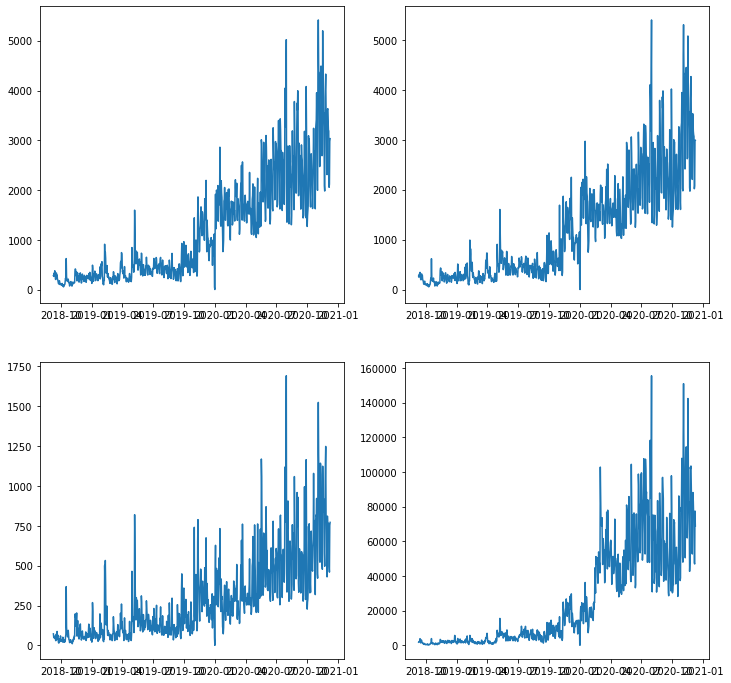

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].plot(train2.iloc[:,count])
    count+=1

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49464 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_

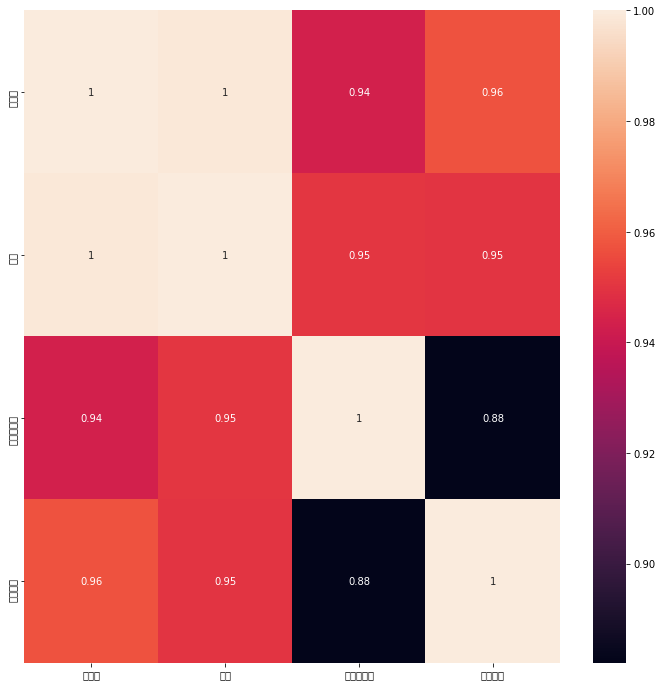

In [ ]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(train2.corr(),annot=True)

In [ ]:
train2 = np.log(train2)

In [ ]:
train2

,사용자,세션,신규방문자,페이지뷰
date,,,,
2018-09-09,5.638355,5.583496,4.290459,7.509883
2018-09-10,5.575949,5.509388,3.931826,7.645876
2018-09-11,5.796058,5.736572,4.060443,7.599902
2018-09-12,5.703782,5.659482,3.806662,7.861342
2018-09-13,5.934894,5.840642,3.912023,8.254529
...,...,...,...,...
2020-12-04,8.067463,8.028781,6.610696,11.234930
2020-12-05,7.628031,7.610358,6.208590,10.771386
2020-12-06,7.658700,7.638680,6.131226,10.756071


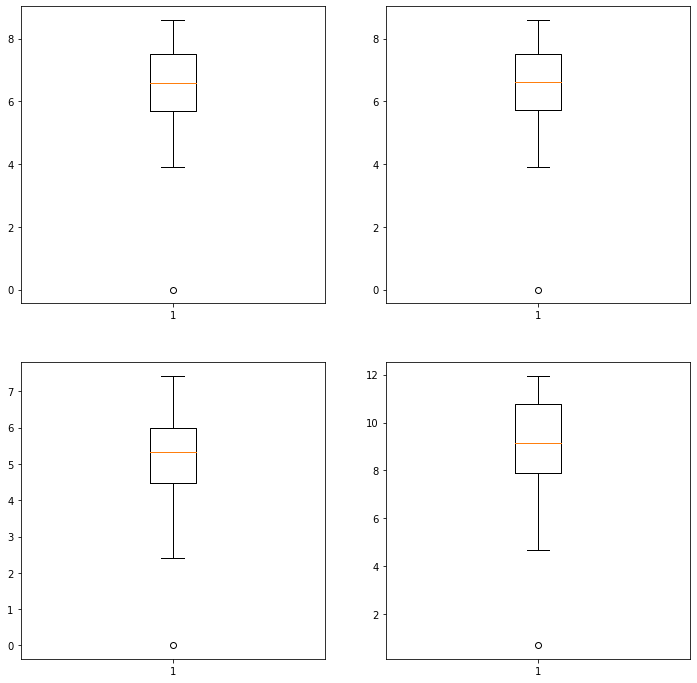

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].boxplot(train2.iloc[:,count])
    count+=1

In [ ]:
train2 = train2[train2.사용자 > 4]

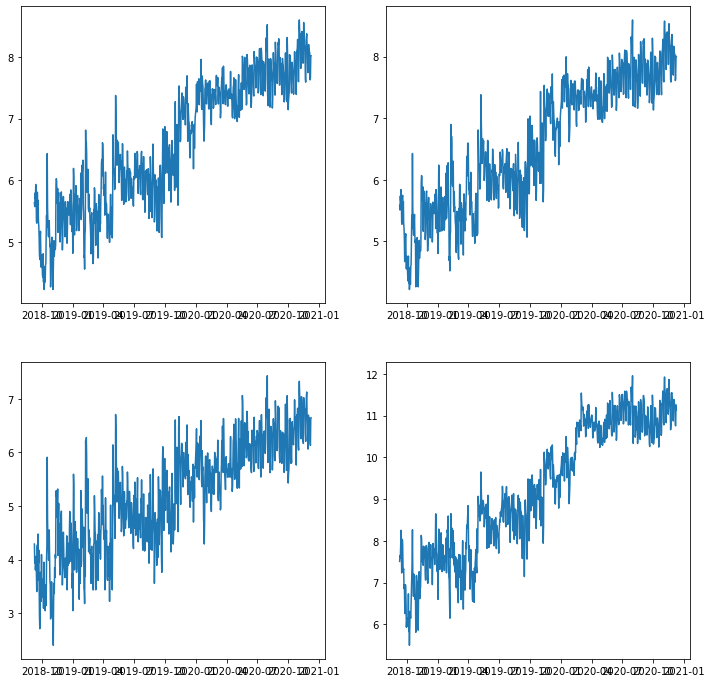

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(12,12))

count = 0
for i in range(0,2):

  for j in range(0,2):

    ax[i][j].plot(train2.iloc[:,count])
    count+=1

In [ ]:
scaler = MinMaxScaler()

index = train2.index

train2 = pd.DataFrame(scaler.fit_transform(train2.values),columns=train2.columns,index=index)

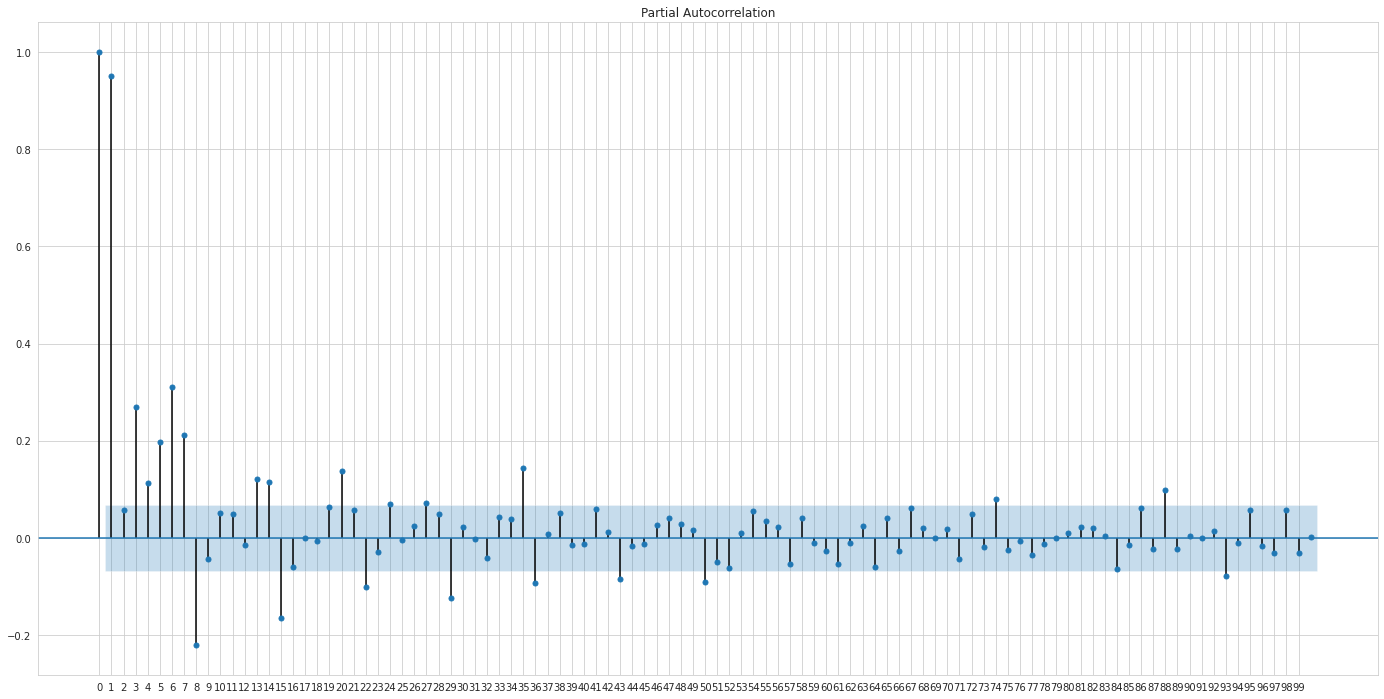

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(24,12))
ax = fig.subplots(1,1)
plot_pacf(train2.사용자,alpha=0.05,zero=True,ax=ax,lags=100)
ax.set_xticks(np.arange(0,100,1))

In [ ]:
def make_dataset(data,steps):
    
    X=[]
    y=[]
    
    for i in range(len(data)):
        
        end = i+steps
        
        if end > len(data)-1:
            
            break
            
        seq_x = data[i:end]
        seq_y = data[end]
        
        X.append(seq_x)
        y.append(seq_y)
        
        
    return np.array(X),np.array(y)

In [ ]:
X, y = make_dataset(train2.values,15)

In [ ]:
X.shape, y.shape

((804, 15, 4), (804, 4))

In [ ]:
last_X=np.concatenate((X[-1][1:],np.array([y[-1]])),axis=0)

In [ ]:
last_X

array([[0.93806643, 0.93665299, 0.92134388, 0.93446129],
       [0.94862711, 0.94611626, 0.93966893, 0.93683986],
       [0.90808831, 0.90159249, 0.85552925, 0.91457415],
       [0.88518772, 0.88124637, 0.85035765, 0.89588429],
       [0.815763  , 0.80962232, 0.8000892 , 0.83916245],
       [0.8046285 , 0.7953622 , 0.72805538, 0.83224661],
       [0.90612163, 0.90243732, 0.85406534, 0.90934823],
       [0.90859311, 0.90002457, 0.83827066, 0.91202543],
       [0.89213207, 0.87852588, 0.82312383, 0.90237917],
       [0.87946233, 0.87313333, 0.84272793, 0.88581173],
       [0.87852997, 0.87076143, 0.83667331, 0.88856595],
       [0.77782089, 0.77511403, 0.756814  , 0.81672907],
       [0.78484949, 0.7815882 , 0.74144939, 0.81435571],
       [0.86291827, 0.86472171, 0.83932846, 0.89203236],
       [0.86703539, 0.86487467, 0.84427751, 0.8738214 ]])

# 3,모델링

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense,Bidirectional
from keras import optimizers
from keras.layers import TimeDistributed


from keras.callbacks import EarlyStopping
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import mean_squared_error
from keras.metrics import RootMeanSquaredError as rmse


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2390757244549790795
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6891740399858892565
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
"""
X_train, y_train = X[:656,:],y[:656,:]
X_val,y_val = X[656:,:],y[656:,:]
"""

'\nX_train, y_train = X[:656,:],y[:656,:]\nX_val,y_val = X[656:,:],y[656:,:]\n'

In [ ]:
strategy = tf.distribute.MirroredStrategy()
early_stopping = EarlyStopping(patience = 200,monitor="val_loss",mode="min")
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
# Code for optimization

"""
loss = []
val_loss = []

with strategy.scope():

  for i in range(10,200,10):

    print("-------------------------------- Number of cell : {}".format(i))


    model = Sequential()
    model.add(LSTM(i,activation="tanh",input_shape=(30,4),return_sequences=True))
    model.add(LSTM(i,activation="tanh"))
    model.add(Dense(4))
    adam = optimizers.Adam(lr=0.003)
    model.compile(optimizer=adam,loss="mse")

    hist = model.fit(X,y,epochs=200,verbose=1,callbacks=[early_stopping],validation_data=(X_val,y_val),batch_size=64)

    fitted_loss = np.array(hist.history["loss"]).mean()
    loss.append(fitted_loss)

    fitted_val_loss = np.array(hist.history["val_loss"]).mean()
    val_loss.append(fitted_val_loss)
  """

'\nloss = []\nval_loss = []\n\nwith strategy.scope():\n\n  for i in range(10,200,10):\n\n    print("-------------------------------- Number of cell : {}".format(i))\n\n\n    model = Sequential()\n    model.add(LSTM(i,activation="tanh",input_shape=(30,4),return_sequences=True))\n    model.add(LSTM(i,activation="tanh"))\n    model.add(Dense(4))\n    adam = optimizers.Adam(lr=0.003)\n    model.compile(optimizer=adam,loss="mse")\n\n    hist = model.fit(X,y,epochs=200,verbose=1,callbacks=[early_stopping],validation_data=(X_val,y_val),batch_size=64)\n\n    fitted_loss = np.array(hist.history["loss"]).mean()\n    loss.append(fitted_loss)\n\n    fitted_val_loss = np.array(hist.history["val_loss"]).mean()\n    val_loss.append(fitted_val_loss)\n  '

In [ ]:
with tf.device('/device:GPU:0'):

  model2 = Sequential()

  model2.add(LSTM(80,input_shape=(15,4),return_sequences=True,activation="tanh"))
  model2.add(LSTM(80,input_shape=(15,4),return_sequences=True,activation="tanh"))
  model2.add(LSTM(80,input_shape=(15,4),return_sequences=False,activation="tanh"))


  model2.add(Dense(4))
  adam = optimizers.RMSprop(learning_rate=0.003)
  model2.compile(optimizer=adam,loss="mse") #metrics=rmse

  for i in range(100,804,50):

    print("---------------------------------CV : {}".format(i))

    X_train, y_train = X[:i,:],y[:i,:]
    X_val, y_val = X[i:,:],y[i:,:]
  
    hist = model2.fit(X_train,y_train,epochs=300,verbose=1,callbacks=[mc],validation_data=(X_val,y_val),batch_size=64)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
10/10 [==============================] - 0s 28ms/step - loss: 4.8579e-05 - val_loss: 0.0182

Epoch 00277: val_loss did not improve from 0.00872
Epoch 278/300
10/10 [==============================] - 0s 28ms/step - loss: 5.4350e-05 - val_loss: 0.0135

Epoch 00278: val_loss did not improve from 0.00872
Epoch 279/300
10/10 [==============================] - 0s 28ms/step - loss: 5.7482e-05 - val_loss: 0.0153

Epoch 00279: val_loss did not improve from 0.00872
Epoch 280/300
10/10 [==============================] - 0s 28ms/step - loss: 5.1628e-05 - val_loss: 0.0146

Epoch 00280: val_loss did not improve from 0.00872
Epoch 281/300
10/10 [==============================] - 0s 26ms/step - loss: 3.4852e-05 - val_loss: 0.0157

Epoch 00281: val_loss did not improve from 0.00872
Epoch 282/300
10/10 [==============================] - 0s 27ms/step - loss: 5.3894e-05 - val_loss: 0.0135

Epoch 00282: val_loss did not improve from 0.00872
Epoch 283/300
10/10 [=========

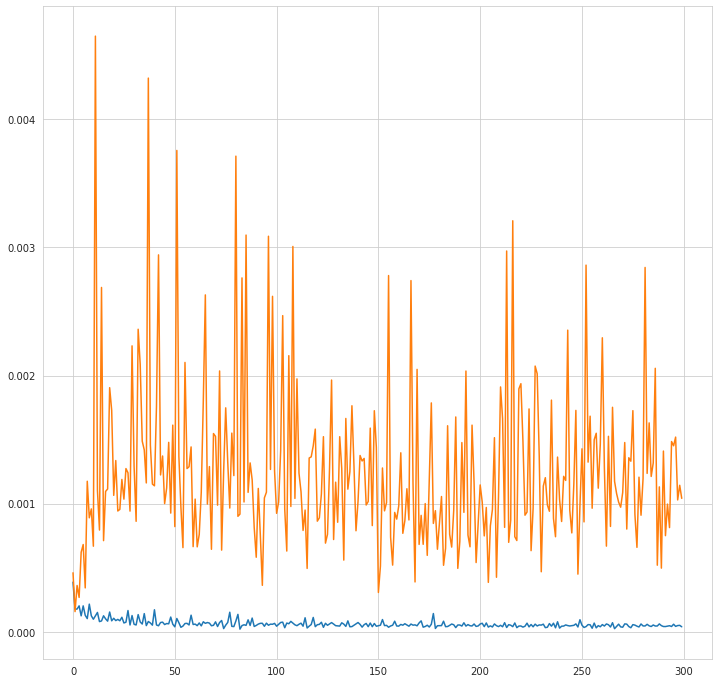

In [ ]:
fig = plt.figure(figsize=(12,12))

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

In [ ]:
np.array(hist.history["val_loss"]).min()

0.00015879930288065225

In [ ]:
pred_model = load_model("/content/best_model.h5")

In [ ]:
pred_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 80)            27200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 80)            51520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 4)                 324       
Total params: 130,564
Trainable params: 130,564
Non-trainable params: 0
_________________________________________________________________


# 4.예측

In [ ]:
X_30 = train2[-15:].values


result = []
for i in range(0,31):
  
  X_sliced = X_30[i:i+15]
  X_reshape = X_sliced.reshape(-1,15,4)
  yhat = pred_model.predict(X_reshape)[0]
  X_30 = np.vstack((X_30,yhat))
  result.append(yhat)

In [ ]:
pred_result = pd.DataFrame(result,columns=train2.columns)

In [ ]:
pred_result = pd.DataFrame(scaler.inverse_transform(pred_result),columns=pred_result.columns)

In [ ]:
pred_result = pd.DataFrame(np.round(np.exp(pred_result.values)),columns=pred_result.columns)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/new_submission.csv",encoding="euc-kr")

In [ ]:
submission = submission.iloc[:,0].to_frame()

In [ ]:
fianl_result = submission.join(pred_result)

In [ ]:
new_train.rename(columns={"date" : "DateTime"},inplace=True)

In [ ]:
fianl_result

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-12-09,3072.0,3142.0,811.0,76694.0
1,2020-12-10,2715.0,2737.0,656.0,63619.0
2,2020-12-11,2460.0,2479.0,573.0,58626.0
3,2020-12-12,1530.0,1536.0,324.0,35378.0
4,2020-12-13,1975.0,1982.0,405.0,49991.0
5,2020-12-14,2683.0,2728.0,625.0,70745.0
6,2020-12-15,2748.0,2726.0,743.0,60894.0
7,2020-12-16,2848.0,2885.0,680.0,69841.0
8,2020-12-17,2617.0,2678.0,668.0,58675.0
9,2020-12-18,2486.0,2504.0,582.0,58748.0


In [ ]:
fianl_result = pd.concat([new_train,fianl_result],axis=0)

In [ ]:
fianl_result

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4364.0,4340.0,1143.0,95408.0
1,2020-11-10,4370.0,4256.0,1137.0,99623.0
2,2020-11-11,4492.0,4449.0,1071.0,114438.0
3,2020-11-12,3998.0,3899.0,796.0,94730.0
4,2020-11-13,4130.0,3967.0,835.0,101484.0
...,...,...,...,...,...
26,2021-01-04,3117.0,3136.0,754.0,83474.0
27,2021-01-05,3333.0,3311.0,808.0,94655.0
28,2021-01-06,2966.0,2925.0,665.0,86429.0
29,2021-01-07,2771.0,2771.0,689.0,74902.0


In [ ]:
fianl_result.to_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/final_result.csv",encoding="euc-kr",index=False)

In [ ]:
sub = pd.read_csv("/content/drive/MyDrive/공모전/2020 DECON CUP/final_result.csv",encoding="euc-kr")

sub

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,4364.0,4340.0,1143.0,95408.0
1,2020-11-10,4370.0,4256.0,1137.0,99623.0
2,2020-11-11,4492.0,4449.0,1071.0,114438.0
3,2020-11-12,3998.0,3899.0,796.0,94730.0
4,2020-11-13,4130.0,3967.0,835.0,101484.0
...,...,...,...,...,...
56,2021-01-04,3117.0,3136.0,754.0,83474.0
57,2021-01-05,3333.0,3311.0,808.0,94655.0
58,2021-01-06,2966.0,2925.0,665.0,86429.0
59,2021-01-07,2771.0,2771.0,689.0,74902.0


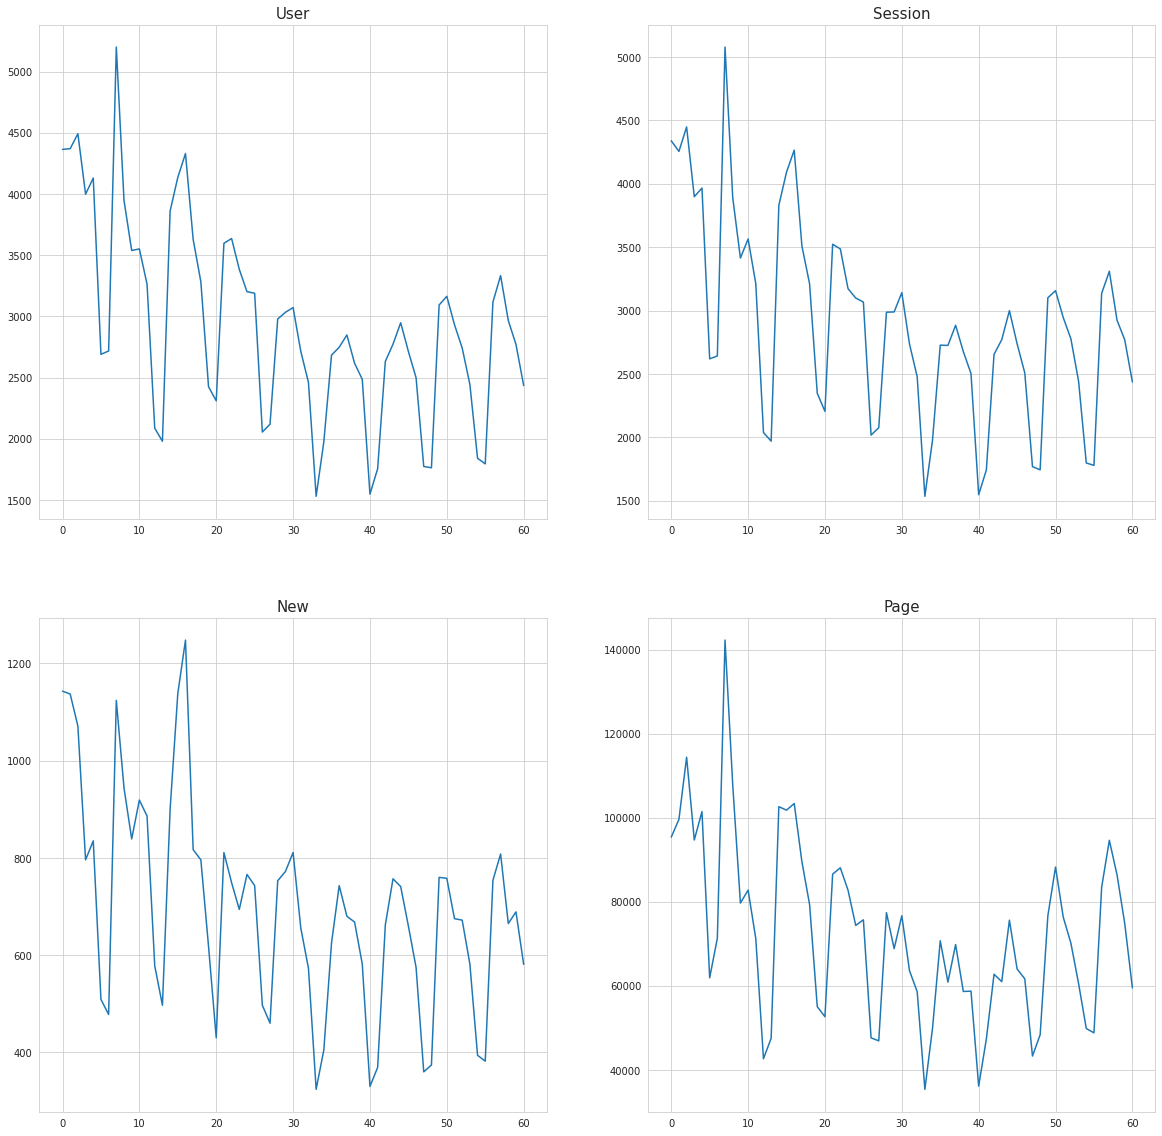

In [ ]:
sns.set_style("whitegrid")

fig,ax = plt.subplots(2,2,figsize=(20,20))

col_name = ["User","Session","New","Page"]

num = 1

for i in range(0,2):

  for j in range(0,2):

    ax[i][j].plot(sub.iloc[:,num])
    ax[i][j].set_title("{}".format(col_name[num-1]),fontsize=15)
    num += 1